# Análise da Rentabilidade de Fundos

### Inicializações

In [1]:
import pandas as pd
from datetime import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

encoding='latin_1'
thousands = ','
decimal = '.'
to_date = lambda d: datetime.strptime(d, '%d-%m-%Y').date()
transacoes_csv = 'transacoes.csv'
cotacoes_xls = 'historico_cotacoes.xlsx'

In [2]:
#Get the Exchange Rates
exchange_rates_csv = 'exchange_rates.csv'
exchange_rates = pd.read_csv(exchange_rates_csv ,sep=';',parse_dates=[0])
exchange_rates['Date'] = exchange_rates['Date'].apply(lambda x: x.date())
exchange_rates = exchange_rates.set_index('Date')['USD2EUR']
exchange_rates.head()

Date
2023-12-26    0.90563
2023-12-25    0.90752
2023-12-24    0.90706
2023-12-23    0.90692
2023-12-22    0.90692
Name: USD2EUR, dtype: float64

### Obter informação de cotações

In [3]:
#Read XLS
dict_df = pd.read_excel(cotacoes_xls,sheet_name=None)

# Parse the date and set it as index
for key in dict_df.keys():
    dict_df[key]['Date'] = dict_df[key].apply(lambda x: pd.to_datetime(x['Date']).date(), axis=1)
    dict_df[key].set_index('Date',drop=True, inplace=True)

# Create the DataFrame from the Dictionary of Dataframes, removing rows with null values
df_cotacoes = pd.concat([dict_df[f_name][['Close']].rename(columns={'Close':f_name}) for f_name in dict_df.keys()],axis=1).sort_index(ascending=False).bfill().ffill()

df_cotacoes

,IE00BLP5S460,LU0197230542,LU0122613903,LU1883314244,LU0286668966,LU1244139660,LU1176912761,LU0140363697,LU0159053015,LU0213962813,...,IE00BD4GTQ32,LU0552900242,LU1495982271,LU0319577374,IE00B23S7K36,FR0000989915,LU0108459040,LU1897414303,LU0173776047,LU1059379971
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-26,1.49,79.90,11.53,153.12,15.13,25.22,116.55,29.85,68.42,42.29,...,14.71,25.60,110.11,104.04,1.46,1613.99,810.50,21.74,21.83,40.64
2023-12-22,1.49,80.19,11.56,153.12,15.16,25.22,116.55,29.76,68.42,42.29,...,14.66,25.60,110.11,104.04,1.46,1613.99,810.50,21.74,21.83,40.64
2023-12-21,1.49,79.56,11.64,152.76,15.19,25.09,116.77,29.82,68.13,42.99,...,14.63,25.40,110.10,103.84,1.46,1613.99,790.21,21.17,21.79,40.39
2023-12-20,1.50,79.66,11.58,153.26,15.23,25.22,116.76,29.55,68.75,42.77,...,14.63,25.51,109.64,103.99,1.45,1626.83,779.30,21.38,21.77,40.56
2023-12-19,1.49,80.87,11.62,152.96,15.19,25.28,117.14,29.99,68.90,42.83,...,14.75,25.42,109.57,103.79,1.47,1611.09,799.38,21.58,21.59,40.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-20,1.23,74.53,27.23,137.43,19.67,36.84,103.31,24.89,54.91,28.60,...,14.83,24.41,104.53,98.02,1.22,2014.09,823.21,17.68,21.05,32.64
2020-11-19,1.23,74.53,27.23,137.43,19.67,36.84,103.31,24.89,54.91,28.60,...,14.83,24.41,104.53,98.02,1.22,2014.09,823.21,17.68,21.05,32.64
2020-11-18,1.23,74.53,27.23,137.43,19.67,36.84,103.31,24.89,54.91,28.60,...,14.83,24.41,104.53,98.02,1.22,2014.09,823.21,17.68,21.05,32.64


### Obter informação de transações

In [4]:
converters={'Data de subscricao': to_date}
df_transacoes = pd.read_csv(transacoes_csv ,sep=',',encoding=encoding,thousands=thousands, decimal=decimal, converters=converters, dtype={'Cotacao de Subscricao':float,'Quantidade':float})
df_transacoes['Data de resgate'] = df_transacoes['Data de resgate'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y').date() if pd.notnull(x) else x)

# Criar Dataframe de Portofolio Actual
df_portofolio = df_transacoes[pd.isnull(df_transacoes['Data de resgate'])].drop(columns=['Data de resgate','Cotacao de resgate']).copy()

i = 0
while df_cotacoes.index[i] > exchange_rates.index[0]:
    exchange_rates[df_cotacoes.index[i]] = exchange_rates[0]
    i += 1
    
last_date = min(df_cotacoes.index[0],exchange_rates.index[0])
# Get the exchange rate for the last date of the historical quotes
usd2eur = exchange_rates.loc[last_date]

df_portofolio['Data da cotacao'] = df_cotacoes.index[0]
df_portofolio['cotacao actual'] = df_portofolio.apply(lambda x: df_cotacoes[x['Code']][0] * (usd2eur if x['Moeda'] == 'USD' else 1), axis=1)
df_portofolio['Dias'] = (df_portofolio['Data da cotacao']-df_portofolio['Data de subscricao']).apply(lambda x: x.days)

# Criar Dataframe com o Historico
df_historico = df_transacoes[pd.notnull(df_transacoes['Data de resgate'])].copy()
df_historico['Dias'] = (df_historico['Data de resgate']-df_historico['Data de subscricao']).apply(lambda x: x.days)
df_historico['Cotacao de resgate'] = df_historico['Cotacao de resgate'].astype(float)

C:\Users\DUARTEMário\AppData\Local\Temp\ipykernel_25028\837864149.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_portofolio['cotacao actual'] = df_portofolio.apply(lambda x: df_cotacoes[x['Code']][0] * (usd2eur if x['Moeda'] == 'USD' else 1), axis=1)


### Cálculo Rentabilidade do Histórico

In [5]:
df_historico['Rentabilidade anual %'] = df_historico.apply(lambda x: 100*(math.pow(x['Cotacao de resgate']/x['Cotacao de Subscricao'],
                                                        float(365.0/x['Dias']))-1), axis=1)
df_historico['Rentabilidade Absoluta'] = df_historico['Cotacao de resgate']*100/df_historico['Cotacao de Subscricao']-100

df_historico['Valor Actual'] = df_historico['Quantidade']*df_historico['Cotacao de resgate']


print("Rentabilidade Absoluta", sum(df_historico['Quantidade']*df_historico['Cotacao de resgate'])*100/sum(df_historico['Quantidade']*df_historico['Cotacao de Subscricao'])-100)

df_historico['Ganho Absoluto'] = df_historico['Quantidade']*(df_historico['Cotacao de resgate']-df_historico['Cotacao de Subscricao'])
print("Ganho Absoluto", sum(df_historico['Ganho Absoluto']),'em', sum(df_historico['Quantidade']*df_historico['Cotacao de Subscricao']))

dias_medio = (df_historico['Quantidade']*df_historico['Cotacao de Subscricao']*df_historico['Dias']).sum() / (df_historico['Quantidade']*df_historico['Cotacao de Subscricao']).sum()
print("Rentabilidade Média Anual", 100*(math.pow(df_historico['Ganho Absoluto'].sum()/sum(df_historico['Quantidade']*df_historico['Cotacao de Subscricao'])+1, float(365.0/dias_medio))-1))


Rentabilidade Absoluta 1.7731251622604844
Ganho Absoluto 15005.615275267262 em 846280.657149802
Rentabilidade Média Anual 3.7990254962948278


In [6]:
df_historico.sort_values(by=['Data de resgate'],ascending=False)

,Code,Nome,Quantidade,Data de subscricao,Cotacao de Subscricao,Moeda,Data de resgate,Cotacao de resgate,Dias,Rentabilidade anual %,Rentabilidade Absoluta,Valor Actual,Ganho Absoluto
44,LU0985320646,Nordea Global Stars E,28.859,2023-09-05,173.2545,EUR,2023-12-18,177.1478,104,8.111561,2.247157,5112.308360,112.356745
43,LU0332193340,GS Glob Energy X,4.999,2023-09-05,999.8900,EUR,2023-12-18,995.9400,104,-1.379592,-0.395043,4978.704060,-19.746050
10,IE00BD4GTQ32,FTGF ClearBridge Infra Val,271.924,2023-11-06,14.0400,EUR,2023-12-18,14.7100,42,49.949009,4.772080,4000.002040,182.189080
14,LU0319577374,ODDO BHF Exk Polaris Dyn DRW,69.000,2023-11-15,100.7500,EUR,2023-12-18,103.7900,33,38.930462,3.017370,7161.510000,209.760000
36,LU0607983201,Nordea Alpha 15 MA,31.061,2023-12-11,80.4868,EUR,2023-12-18,78.5179,7,-72.511427,-2.446240,2438.844492,-61.156003
...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,LU0171310955,BGF Wor Techn EUR E,34.520,2017-04-20,19.4400,EUR,2019-06-06,28.9700,777,20.610796,49.022634,1000.044400,328.975600
360,LU0260085492,Jupiter Europ Grw,13.920,2017-07-06,31.2800,EUR,2019-06-06,35.9200,700,7.478599,14.833760,500.006400,64.588800
334,LU1321847805,BSF Emer Mkt Strat,15.560,2019-03-08,163.5300,EUR,2019-06-06,160.6900,90,-6.858558,-1.736684,2500.336400,-44.190400
291,LU1548497772,A Artific Intellig,8.305,2017-07-07,104.0600,EUR,2019-06-05,120.4110,698,7.930468,15.713050,1000.013355,135.795055


### Cálculo Rentabilidade do Portfólio

In [7]:
df_portofolio['Rentabilidade anual %'] = df_portofolio.apply(lambda x: 100*(math.pow(x['cotacao actual']/x['Cotacao de Subscricao'],
                                                        float(365.0/x['Dias']))-1), axis=1)

df_portofolio['Rentabilidade Absoluta'] = df_portofolio['cotacao actual']*100/df_portofolio['Cotacao de Subscricao']-100
df_portofolio['Valor Actual'] = df_portofolio['Quantidade']*df_portofolio['cotacao actual']
print("Rentabilidade Absoluta", sum(df_portofolio['Valor Actual'])*100/sum(df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao'])-100)

df_portofolio['Ganho Absoluto'] = df_portofolio['Quantidade']*(df_portofolio['cotacao actual']-df_portofolio['Cotacao de Subscricao'])
print("Ganho Absoluto", sum(df_portofolio['Ganho Absoluto']),'em', sum(df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']),'=', sum(df_portofolio['Valor Actual']))

dias_medio = (df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']*df_portofolio['Dias']).sum() / (df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']).sum()
print("Rentabilidade Média Anual", 100*(math.pow(df_portofolio['Ganho Absoluto'].sum()/sum(df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao'])+1, 
                                                 float(365.0/dias_medio))-1))


Rentabilidade Absoluta 2.410763297362365
Ganho Absoluto 5707.974143115682 em 236770.40999258688 = 242478.38413570257
Rentabilidade Média Anual 10.118222534629261


### Rentabilidade Global

In [8]:

dias_medio = (df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']*df_portofolio['Dias']).sum() 
dias_medio += (df_historico['Quantidade']*df_historico['Cotacao de Subscricao']*df_historico['Dias']).sum()
dias_medio_div = (df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']).sum() + (df_historico['Quantidade']*df_historico['Cotacao de Subscricao']).sum()
dias_medio = dias_medio / dias_medio_div
ganho = df_portofolio['Ganho Absoluto'].sum() + df_historico['Ganho Absoluto'].sum()
ganho_relativo = ganho / (sum(df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']) + sum(df_historico['Quantidade']*df_historico['Cotacao de Subscricao']))
print("Rentabilidade Média Anual", 100*(math.pow(ganho_relativo+1, float(365.0/dias_medio))-1))


Rentabilidade Média Anual 4.587572142100216


In [9]:
df_portofolio[["Code","Nome",'Quantidade','Valor Actual','Ganho Absoluto']].groupby(by=["Code","Nome"]).sum().sort_values(by='Ganho Absoluto', ascending=False)

,,Quantidade,Valor Actual,Ganho Absoluto
Code,Nome,,,
LU1244139660,TRP Glb Technology,883.1200,20170.450732,2456.670732
LU0159053015,JPM US Technology D,156.4210,10702.324820,702.330290
IE00BLP5S460,Jupiter Glb Abs Rt EUR,10078.5520,15017.042480,617.041210
LU0552900242,MSI Glb Property AH,216.3570,5538.739200,538.728930
FR0000989915,Oddo BHF Immobilier CR,8.3410,13462.290590,467.432250
LU0140363697,F Technology N,315.3770,9414.003450,413.987420
LU0108459040,Candriam Biotech C Cap USD,12.6500,9285.265905,365.418254
LU1897414303,Janus Biotech A2 USD,318.9910,6280.421192,328.531191
LU0248183815,Schroder Latam B Accum,199.3800,7825.665000,325.727106


<Axes: xlabel='Date'>

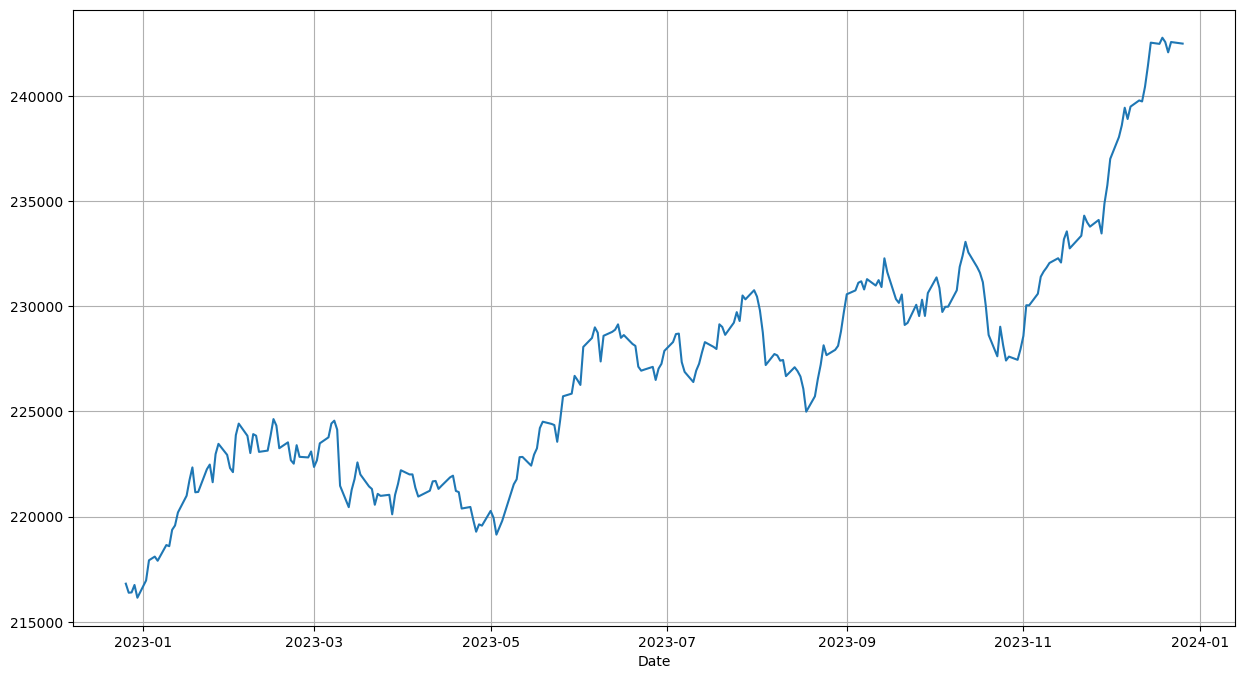

In [10]:
#Get the Portofolio
size=260
portfolio_csv = 'portofolio.csv'
df_meta = pd.read_csv(portfolio_csv ,sep=';').set_index('Code')
#print(set(df_meta.index))
#print(set(df_cotacoes.columns))
df_global = df_cotacoes[:size].apply(lambda x: sum(df_meta['Quantidade'][k]*v*(exchange_rates[x.name] if df_meta['Moeda'][k] == 'USD' else 1) for k,v in x.items()),axis=1)        
df_global[:].plot(figsize=(15,8),grid=True)

In [11]:
start =30
stop = 0
df_global_grow = (df_global / df_global.shift(-1)).dropna()
growth = (df_global.iloc[stop]/df_global.iloc[start]-1)
growth_abs = df_global.iloc[stop] - df_global.iloc[start]
std = df_global_grow.std()
'Growth ABS = {:.2f}, Growth = {:.2%}, STD = {:.6f}, Racio = {:.3f}'.format(growth_abs, growth,std,growth/std)

'Growth ABS = 10199.59, Growth = 4.39%, STD = 0.002994, Racio = 14.666'

# SP 500 Comparision

In [12]:
# https://www.spglobal.com/spdji/en/indices/equity/sp-500/#overview
df_sp500 = pd.read_excel('PerformanceGraphExport.xls', sheet_name="Performance Graph", header=None, names=['Date','Value'], usecols="A:B", skiprows=7).dropna()
ds_sp500 = df_sp500['Value']
ds_sp500.index = df_sp500['Date'].apply(lambda x: x.date())
ds_sp500 = ds_sp500.reindex(pd.date_range(ds_sp500.index.min(),ds_sp500.index.max())).interpolate()
ds_sp500.name = "SP500"
ds_sp500

2013-11-29    1557.49
2013-11-30    1558.33
2013-12-01    1559.17
2013-12-02    1560.01
2013-12-03    1551.49
               ...   
2023-12-18    5100.27
2023-12-19    5096.80
2023-12-20    5027.91
2023-12-21    5072.07
2023-12-22    5070.12
Freq: D, Name: SP500, Length: 3676, dtype: float64

In [13]:
df_sp500_hist = df_historico[['Dias']].copy()
df_sp500_hist['Cost'] = df_historico.apply(lambda x: x['Quantidade']*x['Cotacao de Subscricao'],axis=1)
df_sp500_hist['Quantidade'] = df_historico.apply(lambda x: x['Quantidade']*x['Cotacao de Subscricao']/ds_sp500[np.datetime64(x['Data de subscricao'])],axis=1)

df_sp500_hist['Net'] = df_sp500_hist['Quantidade']*df_historico.apply(lambda x: (ds_sp500[np.datetime64(x['Data de resgate'])]-ds_sp500[np.datetime64(x['Data de subscricao'])]),axis=1)
dias_medio = (df_sp500_hist['Cost']*df_sp500_hist['Dias']).sum() / df_sp500_hist['Cost'].sum()
print("SP500 Histórico: Custo={}, Ganho={}".format(df_sp500_hist['Cost'].sum(),df_sp500_hist['Net'].sum()))
print("Rentabilidade SP500 Histórico", 100*(math.pow(df_sp500_hist['Net'].sum()/sum(df_sp500_hist['Cost'])+1, 
                                                 float(365.0/dias_medio))-1))


SP500 Histórico: Custo=846280.6571498022, Ganho=44578.37727920748
Rentabilidade SP500 Histórico 11.505647454403922


<Axes: >

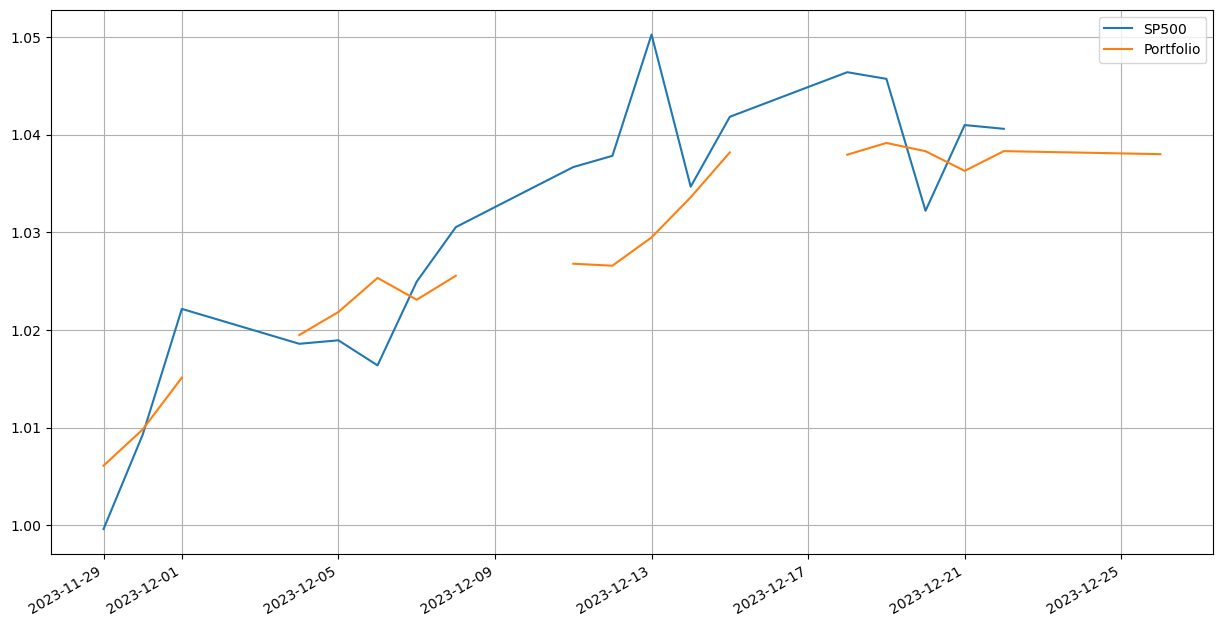

In [14]:
#Comparision of the current portfolio
n_days = 20
df = df_cotacoes[:n_days].apply(lambda x: sum(df_meta['Quantidade'][k]*v*(exchange_rates[x.name] if df_meta['Moeda'][k] == 'USD' else 1) for k,v in x.items()),axis=1).sort_index()
df.index = [pd.Timestamp(x) for x in df.index]
df.name = "Portfolio"
pd.concat([ds_sp500[df.index.min():].pct_change().cumsum()+1, df.pct_change().cumsum()+1],axis=1).plot(figsize=(15,8),grid=True)

<Axes: >

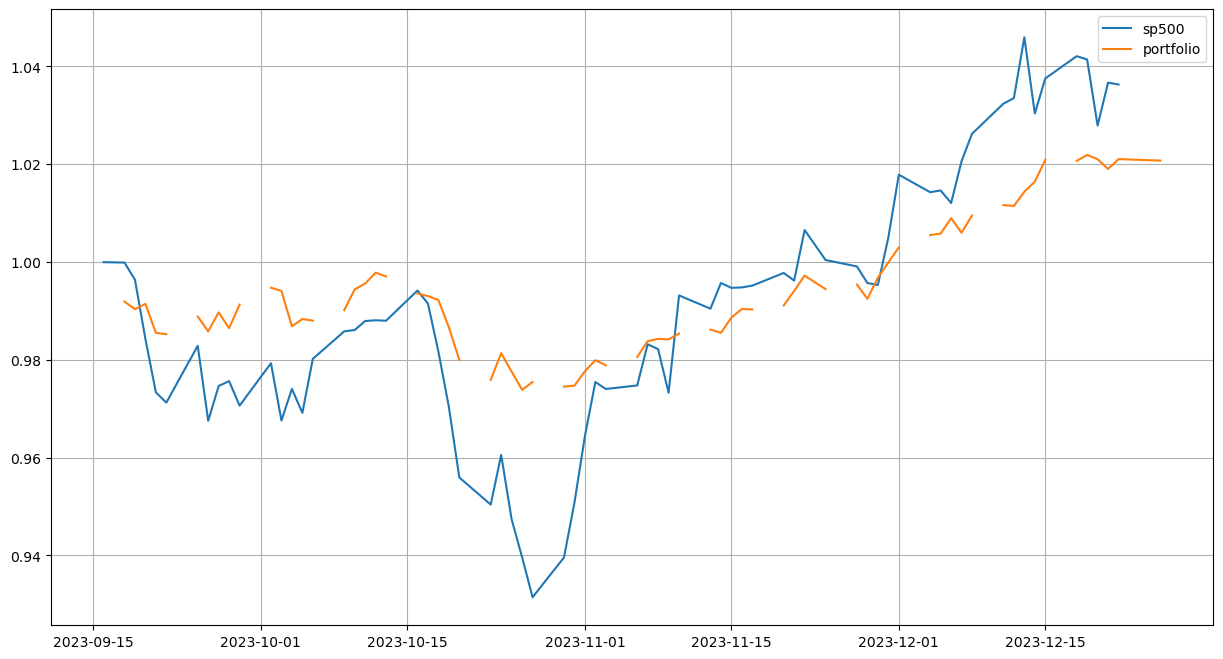

In [15]:
n_days = 71
df_t = df_transacoes[df_transacoes['Code'].isin(df_cotacoes.columns)].copy()
first_date = max(df_cotacoes.index[n_days],df_t['Data de subscricao'].min())
portf_perform = []
df_tmp = df_t[(df_t['Data de subscricao']<=first_date) & ((pd.isnull(df_t['Data de resgate'])) | (df_t['Data de resgate']>first_date))]
last_val = df_tmp.apply(lambda x: x['Quantidade']*df_cotacoes[x['Code']][first_date] * (exchange_rates.loc[first_date] if x['Moeda'] == 'USD' else 1), axis=1).sum()
for i_date in df_cotacoes[:first_date].index.sort_values()[1:]:
    df_tmp = df_t[(df_t['Data de subscricao']<i_date) & ((pd.isnull(df_t['Data de resgate'])) | (df_t['Data de resgate']>=i_date))]
    new_val = df_tmp.apply(lambda x: x['Quantidade']*df_cotacoes[x['Code']][i_date] * (exchange_rates.loc[i_date] if x['Moeda'] == 'USD' else 1), axis=1).sum()
    portf_perform.append(new_val/last_val-1.0)
    df_tmp = df_t[(df_t['Data de subscricao']<=i_date) & ((pd.isnull(df_t['Data de resgate'])) | (df_t['Data de resgate']>i_date))]
    last_val = df_tmp.apply(lambda x: x['Quantidade']*df_cotacoes[x['Code']][i_date] * (exchange_rates.loc[i_date] if x['Moeda'] == 'USD' else 1), axis=1).sum()
portf_perform = pd.Series(data=portf_perform, index= df_cotacoes[:first_date].index.sort_values()[1:], name="portfolio")

sp500_perform = []
last_val = ds_sp500[pd.to_datetime(first_date)]
for i_date in ds_sp500[pd.to_datetime(first_date):].index[1:]:
    sp500_perform.append(ds_sp500[i_date]/last_val-1.0)
    last_val = ds_sp500[i_date]

sp500_perform = pd.Series(data=sp500_perform, index= [x.date() for x in ds_sp500[pd.to_datetime(first_date):].index[1:]], name="sp500")

pd.concat([sp500_perform.cumsum()+1, portf_perform.cumsum()+1],axis=1).plot(figsize=(15,8),grid=True)
